In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [20]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session, Query
from sqlalchemy import create_engine, func, inspect, and_, distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis
Vacation days = December 19 - January 3

### Precipitation Analysis

In [10]:
inspector = inspect(engine)
inspector.get_table_names()
cols = inspector.get_columns('measurement')
for c in cols:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Find the last data point
last_point=session.query(Measurement.date).\
            order_by(Measurement.date.desc()).first()
print(f" Last date is: {last_point[0]}")

# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(f" A year from {last_point[0]} was {year_ago}")

 Last date is: 2017-08-23
 A year from 2017-08-23 was 2016-08-23


In [12]:
# Perform a query to retrieve the data and precipitation scores
last_year = (
            Query(Measurement)
            .filter(Measurement.date >= year_ago)
            .with_entities(Measurement.date, Measurement.prcp)
            .with_session(session)
            .all()
)
last_year

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06'

In [13]:
#  Save the query results as a Pandas DataFrame and set the index to the date column
df_last_year = pd.DataFrame(last_year, columns=["date", "precipitation"])
df_last_year.set_index('date', inplace=True)

# Sort the dataframe by date
df_last_year= df_last_year.sort_index()
df_last_year.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


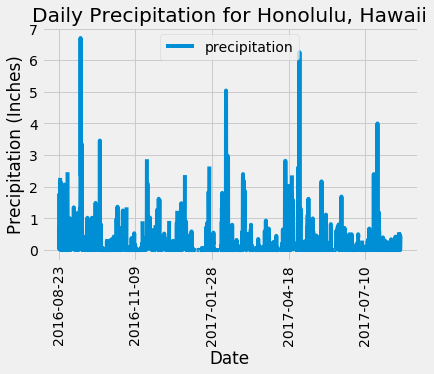

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = df_last_year.plot(rot=90)
ax.set(xlabel="Date",
      ylabel="Precipitation (Inches)",
      title="Daily Precipitation for Honolulu, Hawaii");
plt.savefig("Daily Precipitation.png")

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_last_year.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [16]:
inspector = inspect(engine)
inspector.get_table_names()
cols = inspector.get_columns('station')
for c in cols:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [17]:
# Design a query to show how many stations are available in this dataset
station_total = (
            Query(Station)
            .with_session(session)
            .count()
)
print(f"There are {station_total} stations in the dataset")

There are 9 stations in the dataset


In [44]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
busy_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).\
                desc()).\
                all()
print(f"Station {busy_stations[0][0]} has the highest number of observations")
busy_stations

Station USC00519281 has the highest number of observations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [47]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [func.min(Measurement.tobs),
      func.max(Measurement.tobs),
      func.avg(Measurement.tobs)]

active_station = (
                Query(Measurement)
                .filter(Measurement.station == "USC00519281")
                .with_entities(*sel)
                .with_session(session)
                .all()
)
active_station
print(f"The lowest recorded temperature for station {busy_stations[0][0]} is {active_station[0][0]}")
print(f"The highest recorded temperature for station {busy_stations[0][0]} is {active_station[0][1]}")
print(f"The average temperature for station {busy_stations[0][0]} is {active_station[0][2]}")

The lowest recorded temperature for station USC00519281 is 54.0
The highest recorded temperature for station USC00519281 is 85.0
The average temperature for station USC00519281 is 71.66378066378067


In [57]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
actv_stn_last_year = (
                    Query(Measurement.date)
                    .filter(Measurement.station == "USC00519281", Measurement.date >= year_ago)
#                     .with_entities(func.count(Measurement.station), func.count(Measurement.tobs))
                    .with_entities(Measurement.date, Measurement.tobs)
                    .with_session(session)
                    .all()
)
actv_stn_last_year[:10]

[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0)]

In [58]:
df_asly = pd.DataFrame(actv_stn_last_year, columns=["date", "tobs"])
df_asly.set_index('date', inplace=True)
df_asly

,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


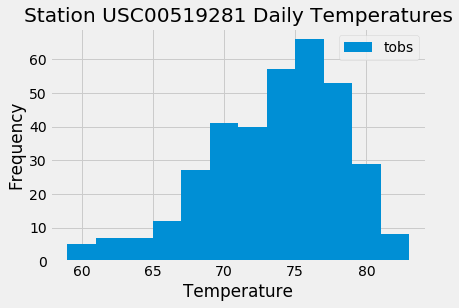

In [66]:
# ax2 = df_last_year.plot(rot=90)
# ax.set(xlabel="Date",
#       ylabel="Precipitation (Inches)",
#       title="Daily Precipitation for Honolulu, Hawaii");
# plt.savefig("Daily Precipitation.png")

ax2=df_asly.plot(kind="hist", bins=12)
ax2.set(xlabel="Temperature",
       title="Station USC00519281 Daily Temperatures");
plt.savefig("Daily Temperatures.png")

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
